In [1]:
%matplotlib inline

In [2]:
from ensemble import Ensemble_LinearRegression
from meta_model import FSSN
from active_anomaly_detector import AAD
from utils import *
from utils_plotting import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils import data

In [3]:
MIN_WINDOW_SIZE   = 5
MAX_WINDOW_SIZE   = 20
TRAIN_WINDOW_SIZE = 100
NUM_MEMBERS       = 50
MEAN_IMPUTE_RATE  = 0.2
UPDATE_PROP       = 0.1
T_0               = 100
targets_to_keep   = None
query_frequency   = None

# Load 20th Yahoo series 

In [5]:
n = 210
df = load_data_yahoo(n)

#Normalize data
mu, s = df['value'].mean(), df['value'].std()
df['value'] = (df['value'] - mu)/s

#Generate a sliding window
df = generate_sliding_window(df, window_size=MAX_WINDOW_SIZE, anomaly_window=False)

#Slit into training and test
train_df, test_df = train_test_split(df, p=0.4)

data/Yahoo/A1Benchmark/real_31.csv


# Convert to Numpy

In [6]:
#Columns in data frame we want to use
train_cols = df.columns[-(MAX_WINDOW_SIZE):]

#Training data 
x_train = train_df[train_cols].to_numpy()
x_test = test_df[train_cols].to_numpy()

#Targets
y_train = train_df['lag0'].to_numpy()
y_test = test_df['lag0'].to_numpy()

#True anomaly values
train_df['anomaly'] = train_df['is_anomaly']
test_df['anomaly'] = test_df['is_anomaly']

y_train_anomalies = train_df[['anomaly']].to_numpy().flatten()
y_test_anomalies = test_df[['anomaly']].to_numpy().flatten()

## Take a look at the series (train and test)

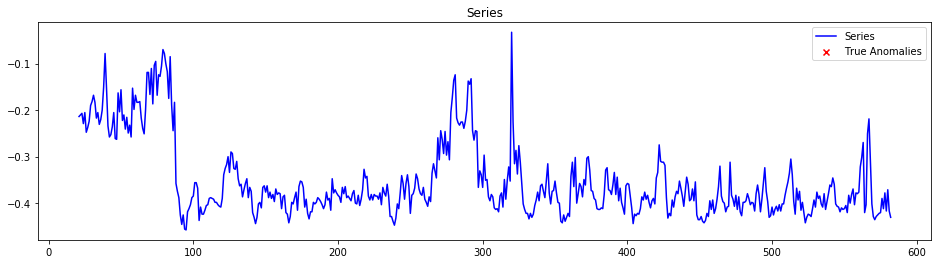

In [7]:
plot_anomaly_series(train_df, column='value')

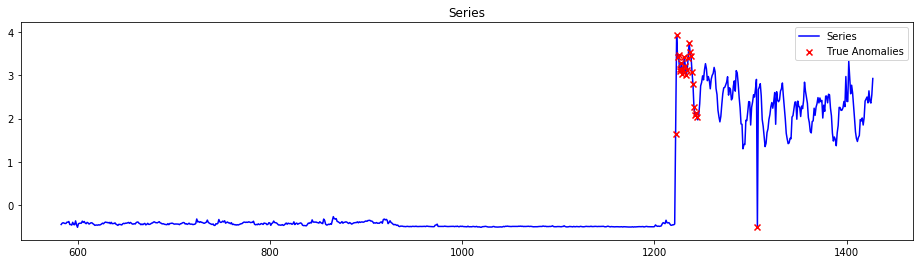

In [8]:
plot_anomaly_series(test_df, column='value')

## Loss function
This function is in `utils.py`

In [9]:
def my_loss(mm_outputs, target, score_x, score_x_prev, q_tau=1., lambda_prior=1.):
    """
    Prepares the loss to update the meta model
    
    Calculates the losses:
        Active Anomaly Detection loss: l_aad = max(0, y(q-score(x_t))) + max(0, y(score(x_t-1)-score(x_t)))
        Prior loss:                    l_prior = ensemble_prior * log(p) + (1-ensemble_prior) * log(p)
        Meta Model Loss:               l_mm = l_aad + lambda_prior * l_prior
        
    Args:
        mm_outputs:     output from meta model
        target:         labeled targets
        q_tau:          threshold
        score_x:        anomaly score at current time step
        score_x_prev:   anomaly score at previous time step
        ensemble_prior: prior for ensemble weights ex. [1/M or 1/sqrt(M)]
        lambda_prior:   constant for amount of weight on l_prior
    """
    if len(target):
        #number of assigned labels
        n_labels = len(target)

        # If n_labels == 0, no labels have been assigned -> l_add = 0
        y_ = torch.tensor(list(target.values()))
        
        l_aad = torch.mean(torch.max(torch.zeros(n_labels, dtype=float), y_ * (q_tau - score_x))) + \
                torch.mean(torch.max(torch.zeros(n_labels, dtype=float), y_ * (score_x_prev - score_x)))
        
    else:
        l_aad = torch.tensor([0])
        
    #calculates ensemble weighting prior
    ensemble_prior = torch.ones(mm_outputs.shape)/mm_outputs.shape[1]
    
    l_prior = F.binary_cross_entropy(mm_outputs, ensemble_prior, reduction='mean')
    
    l_mm = torch.sum(l_aad) + lambda_prior * torch.sum(l_prior)
    return l_mm

# Iniate Ensemble and Meta Model

In [10]:
ensemble_dict = {'LinearRegression':[x for x in np.random.randint(low=MIN_WINDOW_SIZE, high=MAX_WINDOW_SIZE, size=NUM_MEMBERS)]}
ens = Ensemble_LinearRegression(ensemble_dict)

meta_model = FSSN(MAX_WINDOW_SIZE, NUM_MEMBERS)

### Optimizer

In [11]:
optimizer = optim.Adam(meta_model.parameters(), lr=0.001, weight_decay=0)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0)

# AAD

In [12]:
aad = AAD(ens, meta_model, optimizer=optimizer, scheduler=scheduler, query_frequency=0.1)

# Trian model

In [13]:
aad.fit(x_train, y_train,
        y_train_anomalies, 
        train_df, 
        window_size=TRAIN_WINDOW_SIZE, 
        mean_impute_rate=MEAN_IMPUTE_RATE, 
        update_prop=UPDATE_PROP,
        plot=False,
        print_metrics=False)

Epoch: 10, Loss: 0.7231471070087361
Epoch: 10, Loss: 0.15437404195830393
Epoch: 10, Loss: 0.15909687437372633
Epoch: 20, Loss: 0.1561419664140694
Epoch: 30, Loss: 0.15565224567872252
Epoch: 10, Loss: 0.1381548797741169
Epoch: 20, Loss: 0.10492923818438334


# Predict

In [14]:
aad.predict(x_test, y_test,
            y_test_anomalies,
            test_df,
            window_size=TRAIN_WINDOW_SIZE, 
            mean_impute_rate=MEAN_IMPUTE_RATE, 
            update_prop=UPDATE_PROP,
            plot=False)

Epoch: 10, Loss: 0.20259750191905992
Epoch: 20, Loss: 0.1573205132186608
Epoch: 30, Loss: 0.1461932332420337
Epoch: 40, Loss: 0.15720651815116493
Epoch: 50, Loss: 0.12173567720327604
Epoch: 60, Loss: 0.1298413837336625
Epoch: 10, Loss: 0.1380299669796164
Epoch: 20, Loss: 0.11586494477970305
Epoch: 30, Loss: 0.10965625617603564
Epoch: 40, Loss: 0.10960571568997302
Epoch: 50, Loss: 0.10781365290011527
Epoch: 60, Loss: 0.10761961133255177
Epoch: 70, Loss: 0.11270373495909444
Epoch: 80, Loss: 0.10794258155931732
Epoch: 10, Loss: 0.10790892425535938
Epoch: 10, Loss: 0.11211481198497836
Epoch: 10, Loss: 0.1094732475881355
Epoch: 10, Loss: 0.1401147338468992
Epoch: 20, Loss: 0.12827944412287579
auc 0.9996954933008527
f1 : 0.8727272727272727
